In [23]:
# Import Libraries and Constant 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

RANDOM_STATE = 42

In [24]:
# Load Data
# Data download from kaggle Credit Card Fraud Detection https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
df = pd.read_csv('./data/creditcard.csv')
df['Class']  = df['Class'].astype('int8')
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
df['Time']   = pd.to_numeric(df['Time'], errors='coerce')

In [25]:
# Basic sanity
print(df.shape); print(df.dtypes.head())
print(df['Class'].value_counts(), df['Class'].value_counts(normalize=True))
print(df[['Time','Amount']].describe(percentiles=[.5,.9,.99]))

(284807, 31)
Time    float64
V1      float64
V2      float64
V3      float64
V4      float64
dtype: object
Class
0    284315
1       492
Name: count, dtype: int64 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64
                Time         Amount
count  284807.000000  284807.000000
mean    94813.859575      88.349619
std     47488.145955     250.120109
min         0.000000       0.000000
50%     84692.000000      22.000000
90%    157640.400000     203.000000
99%    170560.940000    1017.970000
max    172792.000000   25691.160000


In [26]:
# Train/test split (stratified)
X = df[['Amount','Time']].copy()
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2 , random_state=RANDOM_STATE)

In [27]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit on train
X_test_scaled  = scaler.transform(X_test)

In [28]:
# Naive Baseline
y_pred_proba_zero = np.zeros(len(y_test))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_zero))         # expect 0.5 or error; handle safely
print("PR-AUC :", average_precision_score(y_test, y_pred_proba_zero)) # equals positive class prevalence
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_proba_zero, average='binary', zero_division=0)
print("Precision/Recall/F1:", prec, rec, f1)

ROC-AUC: 0.5
PR-AUC : 0.0017204452090867595
Precision/Recall/F1: 0.0 0.0 0.0


ROC-AUC: 0.6317032475623902
PR-AUC : 0.0029944061123440683
Precision/Recall/F1: 0.0023616236162361626 0.6530612244897959 0.0047062283991469965


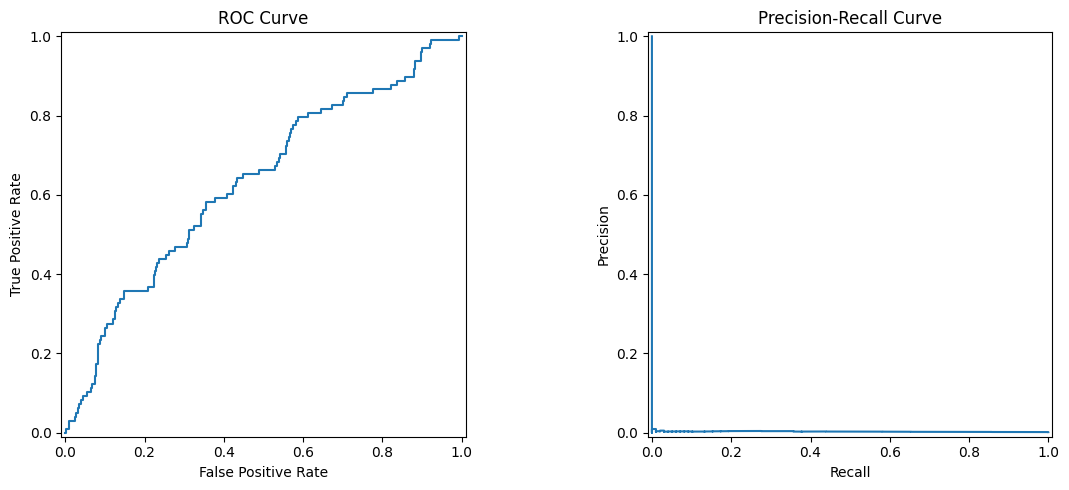

Intercept: [-0.04428643]
Coefficients: {'Amount': np.float64(0.17771853590810707), 'Time': np.float64(-0.25670516017520145)}


In [29]:
# Logistic Regression Baseline
# 1) Train
lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000).fit(X_train_scaled,y_train)

# 2) Predictions
y_pred_proba = lr.predict_proba(X_test_scaled)[:,1]
y_pred = lr.predict(X_test_scaled)

# 3) Metrics
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))         
print("PR-AUC :", average_precision_score(y_test, y_pred_proba))
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
print("Precision/Recall/F1:", prec, rec, f1)

# 4) Curves
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
precisions, recalls, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=plt.gca())
plt.title("ROC Curve")

plt.subplot(1,2,2)
PrecisionRecallDisplay(precision=precisions, recall=recalls).plot(ax=plt.gca())
plt.title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

# 5) Coefficients
print("Intercept:", lr.intercept_)
print("Coefficients:", dict(zip(['Amount','Time'], lr.coef_[0])))